In [1]:
import sys
import os
import shap
import numpy as np
import pandas as pd
import matplotlib

# Set the font family for matplotlib
matplotlib.rcParams["font.family"] = ['serif']

# Add the parent directory to the sys.path to avoid 'ModuleNotFoundError'
sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom modules
from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.helpers import *
from src.config import *
from src.paths import paths

## Load data and models

In [2]:
# Load data
X_train_list = [pd.read_csv(path) for path in paths.get('X_train_paths')]
y_train_list = [pd.read_csv(path) for path in paths.get('y_train_paths')]

X_val_list   = [pd.read_csv(path) for path in paths.get('X_val_paths')]
y_val_list   = [pd.read_csv(path) for path in paths.get('y_val_paths')]

y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

feature_names = X_train_list[0].columns.to_list()

# Concat y_val_list into a sigle list
y_val_agg = concatenate_lists(y_val_list)

# Load trained models of 5 folds
models = {}
for model_name in MODEL_NAMES:
    models[model_name] = []
    for fold in range(5):
        models[model_name].append(load_model_fold(fold, model_name))

## Calculate SHAP values and SHAP interaction values

In [3]:
class ShapValuesCalculator:
    def __init__(self, trained_models):
        self.trained_models = trained_models

    def calculate_shap_values_tree_based(self, model_name, fold_index, X_val):
        explainer = shap.TreeExplainer(
            model=self.trained_models[model_name][fold_index],
            model_output='raw',
            feature_perturbation='tree_path_dependent',
        )
        shap_values = explainer.shap_values(X_val)
        interaction_values = explainer.shap_interaction_values(X_val)

        # SHAP values for Random Forest will be returned for both class 0 and 1.
        # To make all shapes consistent, only extract SHAP values for class 1.
        if model_name == 'rf':
            shap_values = shap_values[..., 1]
            interaction_values = interaction_values[..., 1]

        return shap_values.tolist(), interaction_values.tolist()

    def calculate_shap_values_linear(self, model_name, fold_index, X_train, X_val):
        explainer = shap.LinearExplainer(
            model=self.trained_models[model_name][fold_index],
            masker=X_train,
            model_output='raw',
            feature_perturbation='correlation_dependent',
        )
        shap_values = explainer.shap_values(X_val)
        return shap_values.tolist(), None

    def calculate_shap_values_svm(self, model_name, fold_index, X_train, X_val):
        model = self.trained_models[model_name][fold_index]
        predict_function = lambda x: model.predict_proba(x)[:, 1]
        explainer = shap.KernelExplainer(
            model=predict_function,
            data=X_train,
            nsamples='auto'
        )
        shap_values = explainer.shap_values(X_val)
        return shap_values.tolist(), None

    def process_and_save_shap_values(self, X_train_list, X_val_list, save_paths):
        for model_name in MODEL_NAMES:
            shap_values_list = []
            interaction_values_list = []

            for fold_index, (X_train, X_val) in enumerate(zip(X_train_list, X_val_list)):
                if model_name in ['catboost', 'xgboost', 'lgbm', 'rf']:
                    shap_values, interaction_values = self.calculate_shap_values_tree_based(model_name, fold_index, X_val)
                elif model_name == 'lr':
                    shap_values, _ = self.calculate_shap_values_linear(model_name, fold_index, X_train, X_val)
                    interaction_values = None
                elif model_name == 'svm':
                    shap_values, _ = self.calculate_shap_values_svm(model_name, fold_index, X_train, X_val)
                    interaction_values = None
                else:
                    continue

                if shap_values is not None:
                    shap_values_list.append(shap_values)
                if interaction_values is not None:
                    interaction_values_list.append(interaction_values)

            if shap_values_list:
                save_json(save_paths[model_name]['sv'], shap_values_list)
            if interaction_values_list:
                save_json(save_paths[model_name]['iv'], interaction_values_list)


In [4]:
# shap_calculator = ShapValuesCalculator(models)
# shap_calculator.process_and_save_shap_values(X_train_list, X_val_list, paths)

In [5]:
# Load SHAP values and SHAP interaction values
shap_values = {}
shap_interaction_values = {}

def get_mean_absolute_shap_values(values_by_folds):
    # Concatenate sv of each fold into a single list
    concatenated_values = concatenate_lists(values_by_folds)
    # Get mean absolute SHAP values for this model
    mean_absolute_values = np.mean(np.abs(concatenated_values), axis=0)
    return mean_absolute_values

for model_name in MODEL_NAMES:
    sv_by_folds = load_json(paths[model_name]['sv'])
    shap_values[model_name] = get_mean_absolute_shap_values(sv_by_folds)

    if os.path.isfile(paths[model_name]['iv']):
        iv_by_folds = load_json(paths[model_name]['iv'])
        shap_interaction_values[model_name] = get_mean_absolute_shap_values(iv_by_folds)

print(shap_values.keys())
print(shap_interaction_values.keys())

dict_keys(['catboost', 'xgboost', 'lgbm', 'rf', 'svm', 'lr'])
dict_keys(['catboost', 'xgboost', 'lgbm', 'rf'])


In [6]:
df = pd.DataFrame(shap_values)
df.index = feature_names
df

,catboost,xgboost,lgbm,rf,svm,lr
Gender,0.229443,0.337239,0.395165,0.025956,0.031983,0.541166
Age,0.195943,0.423666,0.510725,0.014509,0.036543,0.194485
Schooling,0.333478,0.626197,0.900210,0.035251,0.067166,0.670598
Breastfeeding,0.357518,0.277856,0.526565,0.019303,0.017774,0.364560
Varicella,0.206302,0.258494,0.099734,0.025884,0.037678,0.347098
Oligoclonal_Bands,0.711712,0.547645,0.582479,0.070517,0.082043,0.945721
LLSSEP,0.064706,0.149383,0.288294,0.024774,0.022360,0.350144
ULSSEP,0.099963,0.141164,0.148613,0.016927,0.008752,0.214012
VEP,0.164262,0.208573,0.163856,0.019059,0.024914,0.395552
BAEP,0.008779,0.039133,0.000000,0.003268,0.008504,0.094401


## Plot heatmap of mean absolute SHAP values for features of models

In [7]:
normalized_df = (df - df.min()) / (df.max() - df.min())
normalized_df = normalized_df.sort_index()
normalized_df

,catboost,xgboost,lgbm,rf,svm,lr
Age,0.164782,0.360779,0.404132,0.097956,0.211324,0.114005
BAEP,0.000000,0.002814,0.000000,0.000000,0.000000,0.035394
Breastfeeding,0.307035,0.225044,0.416666,0.139727,0.069867,0.247591
Cortical_MRI,0.084420,0.140108,0.230796,0.172747,0.094937,0.293252
Gender,0.194276,0.280324,0.312691,0.197701,0.176955,0.386305
Infratentorial_MRI,0.431856,0.605914,0.587315,0.634533,0.556280,0.778391
LLSSEP,0.049239,0.105447,0.228125,0.187399,0.104433,0.236267
Mono_Symptomatic,0.026267,0.329588,0.451334,0.017857,0.162045,0.098173
Oligoclonal_Bands,0.618874,0.476192,0.460911,0.585997,0.554262,0.704063
Periventricular_MRI,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


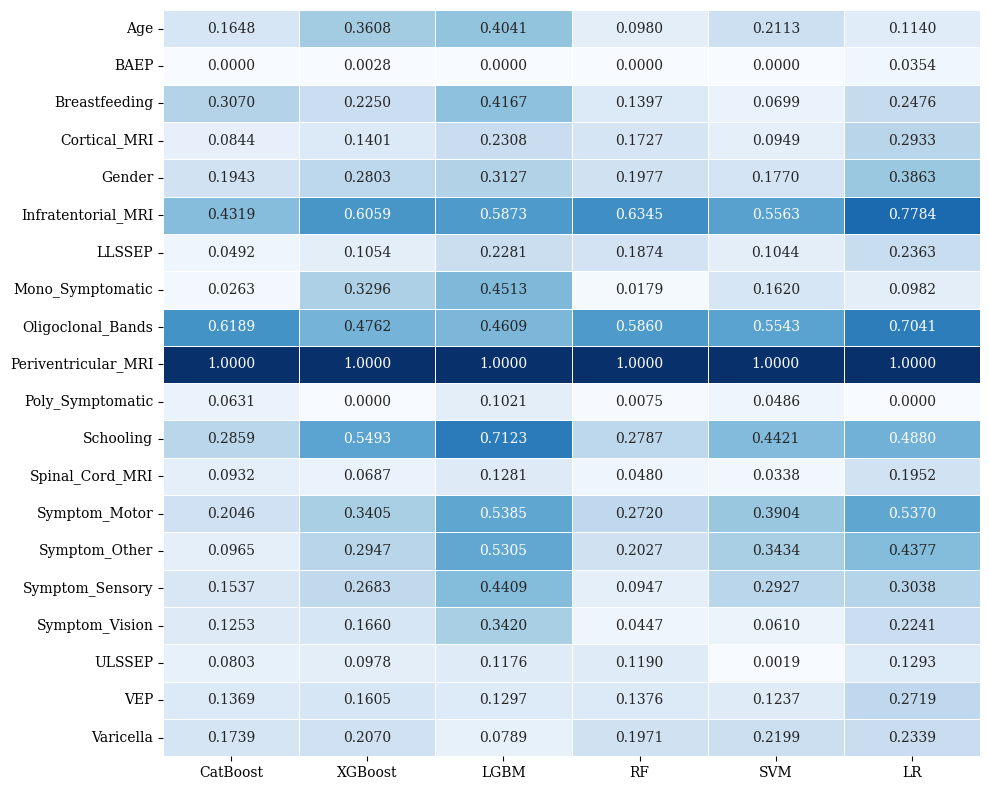

In [8]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_df, annot=True, cmap="Blues", linewidths=.5, cbar=False, fmt=".4f")
plt.ylabel('')

# Set custom x-tick labels
xticklabels = ['CatBoost', 'XGBoost', 'LGBM', 'RF', 'SVM', 'LR']
plt.xticks(ticks=plt.xticks()[0], labels=xticklabels, ha='center')

# Save and show the plot
plt.tight_layout()
plt.savefig('../img/feature_importance_heatmap.jpeg', format='jpeg', dpi=600)
plt.show()

## Plot feature rankings

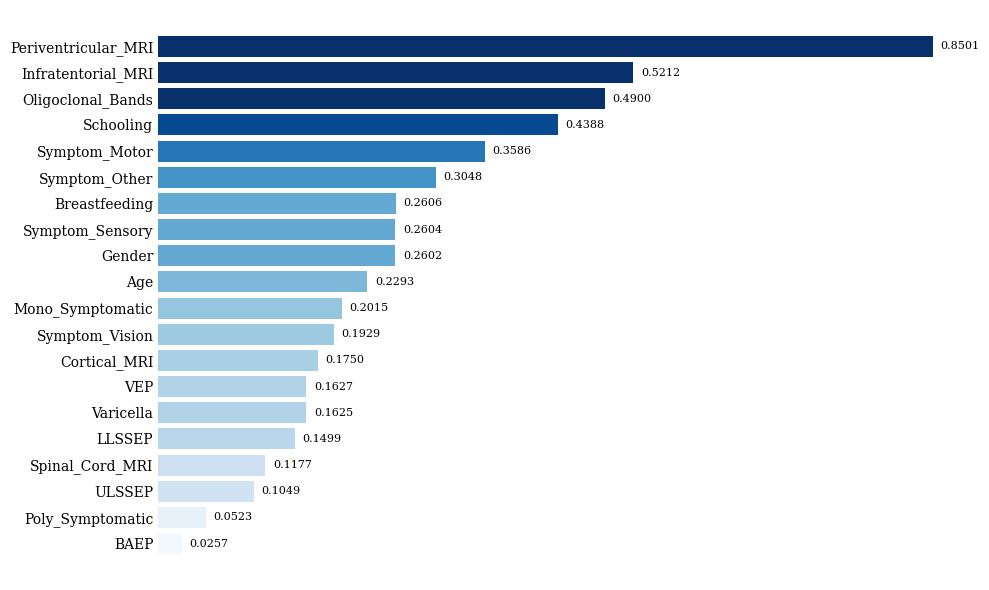

In [9]:
# Add a column 'Mean' to store mean SHAP values of each feature
df['Mean'] = df.mean(axis=1)

# Sort the DataFrame by the mean_value column in ascending order
df_sorted = df.sort_values('Mean', ascending=True)

# Normalize the values for colormap
norm = plt.Normalize(df_sorted['Mean'].min(), df_sorted['Mean'].max())
cmap = plt.cm.Blues

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(
    df_sorted.index,
    df_sorted['Mean'],
    color=cmap(norm(df_sorted['Mean']*1.75))
)

# Hide top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide ticks but keep ticklabels
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks([])

# Add value text to the right of each bar
for i in ax.patches:
    ax.text(i.get_width() + 0.03, i.get_y() + i.get_height() / 2,
            f'{i.get_width():.4f}', ha='center', va='center', fontsize=8, color='black')

# Save the plot
plt.tight_layout()
plt.savefig('../img/feature_ranking.jpeg', format='jpeg', dpi=600)

# Display the plot
plt.show()
